In [48]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

#load the dataset
data=sns.load_dataset('titanic')

#null and duplicate values
# deck has 77% null values
data.drop('deck',axis=1,inplace=True)
data.drop('embark_town',axis=1,inplace=True)
data['age']=data['age'].fillna(data['age'].mean())
data['embarked']=data['embarked'].fillna(data['embarked'].mode()[0])

data.drop_duplicates(inplace=True)

data=data.drop('alive',axis=1)

In [49]:
#outlier detection
from scipy.stats import zscore
import numpy as np

z_score=np.abs(zscore(data['age']))
outlier=data[(z_score>3)]
data=data.drop(outlier.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    776 non-null    int64   
 1   pclass      776 non-null    int64   
 2   sex         776 non-null    object  
 3   age         776 non-null    float64 
 4   sibsp       776 non-null    int64   
 5   parch       776 non-null    int64   
 6   fare        776 non-null    float64 
 7   embarked    776 non-null    object  
 8   class       776 non-null    category
 9   who         776 non-null    object  
 10  adult_male  776 non-null    bool    
 11  alone       776 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(3)
memory usage: 63.0+ KB


In [50]:
# encoding
from sklearn.preprocessing import LabelEncoder

object_col=data.select_dtypes(include=['object','category','bool']).columns
le=LabelEncoder()

for col in object_col:
  le=LabelEncoder()
  data[col]=le.fit_transform(data[col])

data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alone
0,0,3,1,22.000000,1,0,7.2500,2,2,1,1,0
1,1,1,0,38.000000,1,0,71.2833,0,0,2,0,0
2,1,3,0,26.000000,0,0,7.9250,2,2,2,0,1
3,1,1,0,35.000000,1,0,53.1000,2,0,2,0,0
4,0,3,1,35.000000,0,0,8.0500,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,0,39.000000,0,5,29.1250,1,2,2,0,0
887,1,1,0,19.000000,0,0,30.0000,2,0,2,0,1
888,0,3,0,29.699118,1,2,23.4500,2,2,2,0,0
889,1,1,1,26.000000,0,0,30.0000,0,0,1,1,1


In [51]:
#split x and y
x=data.drop('survived',axis=1)
y=data['survived']

In [52]:
# feature selection (ANOVA)
from sklearn.feature_selection import SelectKBest,f_classif,chi2

selector=SelectKBest(f_classif,k=8)
selector.fit_transform(x,y)
k=selector.get_support()
new_col=[]
for i in range(len(k)):
  if k[i]==True:
    new_col.append(x.columns[i])
x_new=x[new_col]

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVC
param_grid = {
    'C': [0.1, 1, 10],             # Regularization strength
    'kernel': ['linear', 'rbf'], # Kernel type
    'gamma': ['scale',  0.1]  # Kernel coefficient
}

# Create the SVC model
svc = SVC()

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',  # Change to 'f1', 'precision', etc. if needed
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1             # Use all CPU cores
)

# Fit the model
grid_search.fit(x, y)

# Display the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Score: 0.8028205128205128


In [54]:
#model building with cross validation
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

model=SVC(C=1, gamma='scale', kernel= 'linear')

cv_score=cross_val_score(model,x,y,cv=5)
print(cv_score)
print(cv_score.mean())

[0.81410256 0.80645161 0.78709677 0.76774194 0.83870968]
0.8028205128205128


✅ Accuracy: 0.8028350515463918
🔍 Precision (macro): 0.7991835585585585
🔍 Recall (macro): 0.791041046181233
🔍 F1 Score (macro): 0.7941947841461617

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       455
           1       0.78      0.72      0.75       321

    accuracy                           0.80       776
   macro avg       0.80      0.79      0.79       776
weighted avg       0.80      0.80      0.80       776

📊 Confusion Matrix:
[[391  64]
 [ 89 232]]


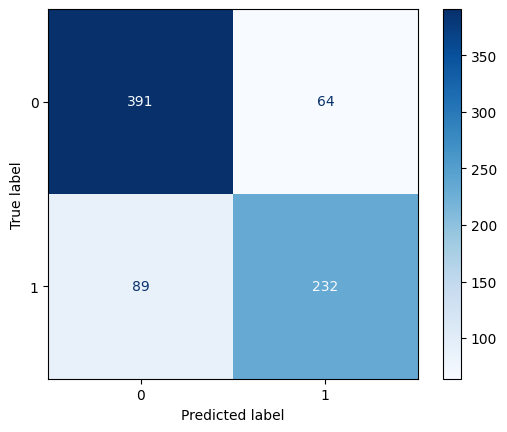

In [55]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Define model
model = SVC(C=1, gamma='scale', kernel='linear')

# Cross-validated predictions
y_pred = cross_val_predict(model, x, y, cv=5)

# Metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')
report = classification_report(y, y_pred)
cm = confusion_matrix(y, y_pred)

# Print metrics in your style
print(f"✅ Accuracy: {accuracy}")
print(f"🔍 Precision (macro): {precision}")
print(f"🔍 Recall (macro): {recall}")
print(f"🔍 F1 Score (macro): {f1}\n")

print("📋 Classification Report:\n")
print(report)

print("📊 Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
